In [1]:
import  torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_batch(x):
    if type(x) == torch.Tensor:
        x = x.cpu().numpy()

    n_cols = x.shape[0]
    fig, axs = plt.subplots(1, n_cols)
    for idx in range(x.shape[0]):
        ax = axs[idx]
        img = x[idx]
        ax.imshow(img, cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def get_latent_img(decoder, n=30, d_z=2, random_samples=False):
    x_limit = np.linspace(-2, 2, n)
    y_limit = np.linspace(-2, 2, n)
    #
    img = np.empty((28 * n, 28 * n))
    #
    for i, zi in enumerate(x_limit):
        for j, pi in enumerate(y_limit):
            
            if random_samples:
                latent_layer = np.random.normal(0, 1, size=[1, d_z])
            else:
                latent_layer = np.array([[zi, pi]])
            
            latent_layer = torch.Tensor(latent_layer)
            latent_layer = latent_layer.to(device)
            with torch.no_grad():
                x_gen = decoder(latent_layer)
            x_gen = x_gen.cpu().numpy()
            img[(n-i-1)*28:(n-i)*28,
                j*28:(j+1)*28] = x_gen[0].reshape((28, 28))
    return img

def scatter_with_legend(Z, Y):
    x = Z[:, 0]
    y = Z[:, 1]
    classes = Y
    
    unique = np.unique(classes)
    colors = [plt.cm.jet(i/float(len(unique)-1)) for i in range(len(unique))]
    for i, u in enumerate(unique):
        xi = [x[j] for j  in range(len(x)) if classes[j] == u]
        yi = [y[j] for j  in range(len(x)) if classes[j] == u]
        plt.scatter(xi, yi, color=colors[i], label=u, alpha=0.5)
    plt.legend()

    plt.show()

class Encoder(nn.Module):
    def __init__(self, d_in, d_hidden, d_z):
        super(Encoder, self).__init__()
        
        self.d_z = d_z
        
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden),
            nn.ReLU(),
            #nn.Linear(d_hidden, d_hidden),
            #nn.ReLU(),
        )
        self.net_mean = nn.Sequential(
            nn.Linear(d_hidden, d_z),
            #nn.ReLU()
        )
        self.net_logvar = nn.Sequential(
            nn.Linear(d_hidden, d_z),
            #nn.Softplus()
        )
    def forward(self, x):
        inter = self.net(x)
        z_mu = self.net_mean(inter)
        
        # we predict log_var = log(std**2)
        # -> std = exp(0.5 * log_var)
        # -> alternative is to directly predict std ;)
        z_logvar = self.net_logvar(inter)
        
        return z_mu, z_logvar

class Decoder(nn.Module):
    def __init__(self, d_z, d_hidden, d_out):
        super(Decoder, self).__init__()
        #
        self.net = nn.Sequential(
            nn.Linear(d_z, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_out),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

def reparametrize(mu, logvar):
    eps = torch.randn_like(logvar)
    512
    return eps * std + mu

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

        
def fn_loss_rec(x_ori, x_rec):
    # Alternative MSE
    #loss = F.mse_loss(x_ori, x_rec)
    
    # Binary Cross Entropy
    # loss = F.binary_cross_entropy(x_rec, x_ori, reduction='sum')
    loss = x_ori * torch.log(1e-10 + x_rec) + (1 - x_ori) * torch.log(1 - x_rec)
    loss = - torch.sum(loss, axis=1)
    
    return loss

def fn_loss_kld(mu, logvar):
    #
    loss = 1 + logvar - mu ** 2 - logvar.exp()
    loss = -0.5 * torch.sum(loss, dim = 1)
    return loss

def fn_loss(x_ori, x_rec, mu, logvar, alpha=1, beta=1):
    
    loss_rec = fn_loss_rec(x_ori, x_rec).mean()
    loss_kld = fn_loss_kld(mu, logvar).mean()
    
    loss = alpha * loss_rec + beta * loss_kld
    return loss, loss_rec, loss_kld

In [27]:
lr = 1e-3
num_epochs = 10
batch_size = 1024
#
d_in = 28**2
d_z = 2
d_hidden = 512
#
device = "cuda:0"

In [50]:
# DATA
dl_train = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=T.Compose([
                               T.ToTensor(),
                               #T.Normalize((0.1307,), (0.3081,)),
                               T.Lambda(lambda x: torch.flatten(x))
                             ])),
  batch_size=batch_size, shuffle=True)

dl_valid = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=T.Compose([
                               T.ToTensor(),
                               #T.Normalize((0.1307,), (0.3081,)),
                               T.Lambda(lambda x: torch.flatten(x))
                             ])),
  batch_size=batch_size, shuffle=True)

torch.Size([1024, 784])


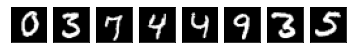

In [51]:
#### RECONSTRUCTION SAMPLE IMGS
n_vis = 8
x_vis, _ = next(iter(dl_valid))
print(x_vis.shape)
x_vis = x_vis[:n_vis, :]
x_vis_ori = torch.reshape(x_vis, (n_vis, 28, 28)).numpy()
#
plot_batch(x_vis_ori)

# NOISE IMGS

In [52]:
# MODEL
encoder = Encoder(d_in, d_hidden, d_z)
decoder = Decoder(d_z, d_hidden, d_in)
#
encoder.apply(init_weights)
decoder.apply(init_weights)

# OPTIMIZER
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

In [53]:
dist = Normal(torch.zeros(d_z),
              torch.ones(d_z))

Epoch [   0/  10] step     0: Loss: 547.2948, REC: 547.0896 KLD: 0.2052, APRX: 0.1086


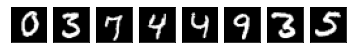

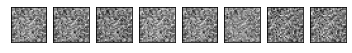

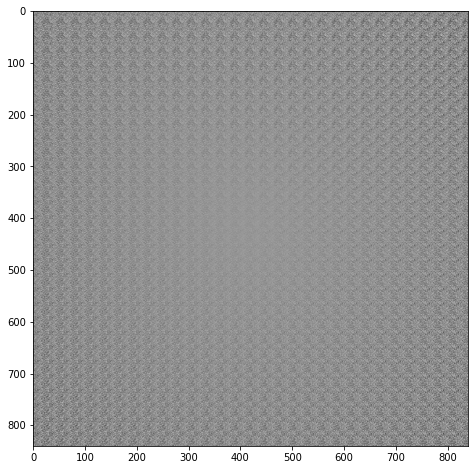

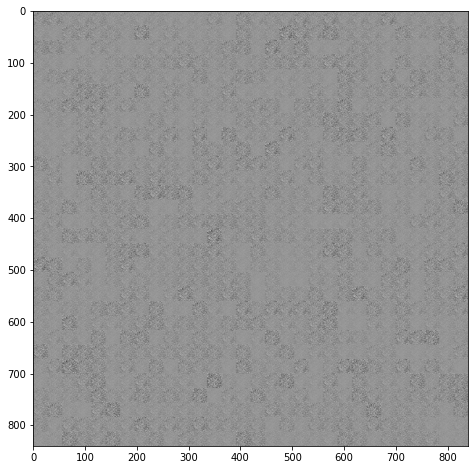

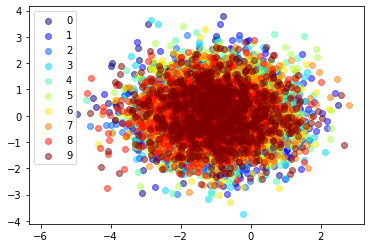

Epoch [   0/  10] step    10: Loss: 285.2966, REC: 245.4715 KLD: 39.8252, APRX: 19.8456
Epoch [   0/  10] step    20: Loss: 223.1232, REC: 216.8155 KLD: 6.3076, APRX: 3.1518
Epoch [   0/  10] step    30: Loss: 209.3275, REC: 205.7363 KLD: 3.5912, APRX: 1.7653
Epoch [   0/  10] step    40: Loss: 206.6289, REC: 203.4540 KLD: 3.1749, APRX: 1.5671
Epoch [   0/  10] step    50: Loss: 200.9184, REC: 198.2545 KLD: 2.6639, APRX: 1.3297
Epoch [   1/  10] step    60: Loss: 196.9424, REC: 194.2274 KLD: 2.7151, APRX: 1.3408
Epoch [   1/  10] step    70: Loss: 190.9430, REC: 187.7966 KLD: 3.1464, APRX: 1.5692
Epoch [   1/  10] step    80: Loss: 187.4476, REC: 184.0337 KLD: 3.4138, APRX: 1.7266
Epoch [   1/  10] step    90: Loss: 185.0918, REC: 181.4174 KLD: 3.6743, APRX: 1.8332
Epoch [   1/  10] step   100: Loss: 181.8159, REC: 178.0304 KLD: 3.7855, APRX: 1.8848
Epoch [   1/  10] step   110: Loss: 181.3302, REC: 177.4509 KLD: 3.8794, APRX: 1.9682
Epoch [   2/  10] step   120: Loss: 178.2052, REC: 1

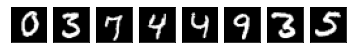

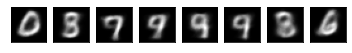

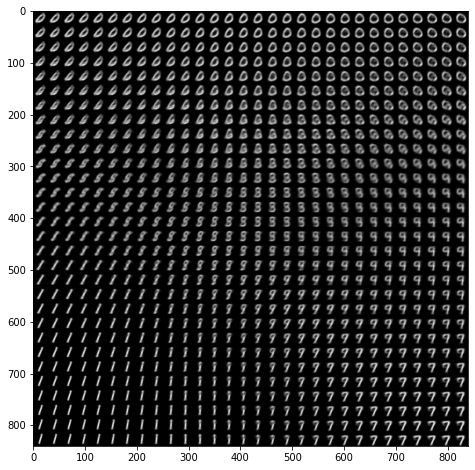

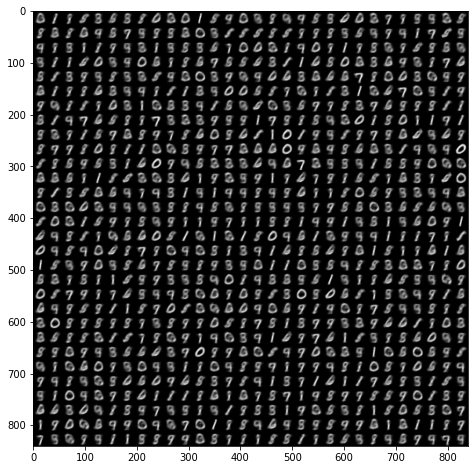

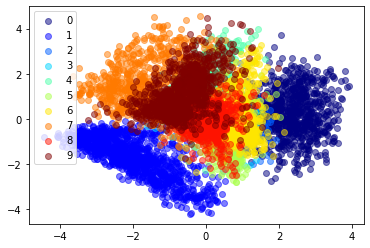

Epoch [   8/  10] step   510: Loss: 161.0648, REC: 155.9187 KLD: 5.1460, APRX: 2.5738
Epoch [   8/  10] step   520: Loss: 159.2363, REC: 153.9383 KLD: 5.2981, APRX: 2.6520
Epoch [   8/  10] step   530: Loss: 157.4337, REC: 152.1817 KLD: 5.2520, APRX: 2.6348
Epoch [   9/  10] step   540: Loss: 161.0107, REC: 155.6724 KLD: 5.3383, APRX: 2.6644
Epoch [   9/  10] step   550: Loss: 160.6465, REC: 155.4982 KLD: 5.1483, APRX: 2.5792
Epoch [   9/  10] step   560: Loss: 159.1873, REC: 153.9298 KLD: 5.2576, APRX: 2.6240
Epoch [   9/  10] step   570: Loss: 158.8245, REC: 153.5143 KLD: 5.3102, APRX: 2.6324
Epoch [   9/  10] step   580: Loss: 159.7204, REC: 154.3805 KLD: 5.3399, APRX: 2.6678


In [54]:
#
s_loss = []
s_loss_kld = []
s_loss_rec = []
s_loss_nll = []
#
alpha = 1
beta = 1
gamma = 0
#
encoder = encoder.to(device)
decoder = decoder.to(device)
#
step = 0
#
for epoch_idx in range(num_epochs):
    encoder.train()
    decoder.train()
    for x, _ in dl_train:
        x = x.to(device)
        mu, logvar = encoder(x)
        z = reparametrize(mu, logvar)
        x_rec = decoder(z)
        
        # LOSS
        #----------------------------------------
        loss_rec = fn_loss_rec(x, x_rec).mean()
        loss_kld = fn_loss_kld(mu, logvar).mean()
        
        loss_p = - dist.log_prob(z.cpu()).mean()
    
        std2 = torch.exp(0.5 * logvar)
        dist2 = Normal(mu, std2)

        loss_q = dist2.log_prob(z).mean()
        
        loss_aprox = loss_p + loss_q
    
        #loss = alpha * loss_rec + beta * loss_kld
        loss = alpha * loss_rec + beta * loss_kld + gamma * loss_aprox
        #loss, loss_rec, loss_kld = fn_loss(x, x_rec, mu, logvar, alpha, beta)
        
        
        s_loss.append(loss.item())
        s_loss_kld.append(loss_kld.item())
        s_loss_nll.append(loss_aprox.item())
        s_loss_rec.append(loss_rec.item())
        # ---------------------------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #
        
        if step % 10 == 0:
            print_str = "Epoch [{:4}/{:4}] step {:5}: Loss: {:.4f}, REC: {:.4f} KLD: {:.4f}, APRX: {:.4f}"
            print_str = print_str.format(epoch_idx, num_epochs, step, loss.item(),
                                        loss_rec.item(), loss_kld.item(),
                                        loss_aprox.item())
            print(print_str)
        if step % 500 == 0:
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                x_vis = x_vis.to(device)
                mu, logvar = encoder(x_vis)
                z = reparametrize(mu, logvar)
                x_vis_rec = decoder(z)
                x_vis_rec = x_vis_rec.cpu().numpy().reshape((-1, 28, 28))
            plot_batch(x_vis_ori)
            plot_batch(x_vis_rec)
        
        if step % 500 == 0 and d_z == 2:
            img = get_latent_img(decoder, random_samples=False)
            fig, axs = plt.subplots(1, 1, figsize=(8, 8))
            axs.imshow(img, cmap="gray")
            plt.show()
        if step % 500 == 0:
            img = get_latent_img(decoder, random_samples=True)
            fig, axs = plt.subplots(1, 1, figsize=(8, 8))
            axs.imshow(img, cmap="gray")
            plt.show()
        if step % 500 == 0 and d_z == 2:
            Z = []
            Y = []
            with torch.no_grad():
                for x, y in dl_valid:
                    x = x.to(device)
                    mu, logvar = encoder(x)
                    z = reparametrize(mu, logvar)
                    Z.append(z.cpu().numpy())
                    Y.append(y.numpy())
            Z = np.concatenate(Z)
            Y = np.concatenate(Y)
            scatter_with_legend(Z, Y)
        step += 1



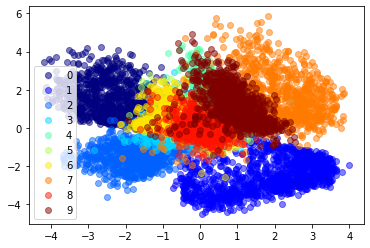

In [47]:
Z = []
Y = []
with torch.no_grad():
    for x, y in dl_valid:
        x = x.to(device)
        mu, logvar = encoder(x)
        z = reparametrize(mu, logvar)
        Z.append(z.cpu().numpy())
        Y.append(y.numpy())
    Z = np.concatenate(Z)
    Y = np.concatenate(Y)
    scatter_with_legend(Z, Y)

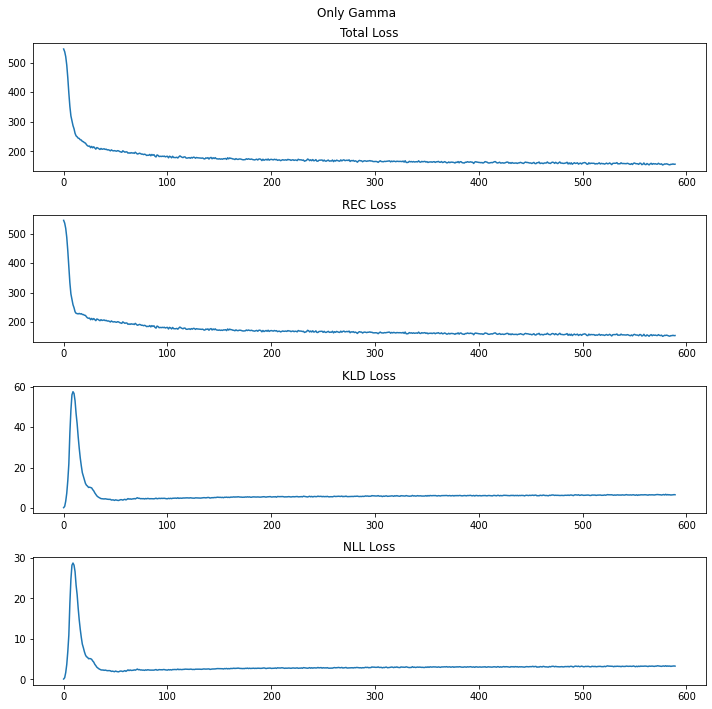

In [48]:
xx = range(len(s_loss))
#
fig, axes = plt.subplots(4, 1, figsize=(10, 10))
axes[0].plot(xx, s_loss)
axes[0].set_title("Total Loss")

axes[1].plot(xx, s_loss_rec)
axes[1].set_title("REC Loss")

axes[2].plot(xx, s_loss_kld)
axes[2].set_title("KLD Loss")

axes[3].plot(xx, s_loss_nll)
axes[3].set_title("NLL Loss")

plt.suptitle("Only Gamma")
plt.tight_layout()

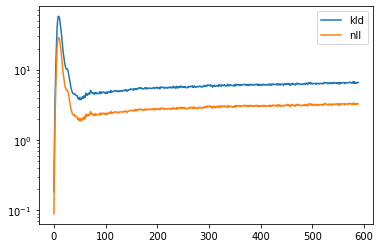

In [49]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

ax.set_yscale('log')

ax.plot(xx, s_loss_kld, label="kld")
ax.plot(xx, s_loss_nll, label="nll")
plt.legend()

In [ ]:
np.mean(s_loss_kld[-10:])